In [1]:
# TODO
# windowing seems off 

In [1]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import matplotlib.pyplot as plt

from Helpers import create_rolling_windows 

# Dataset

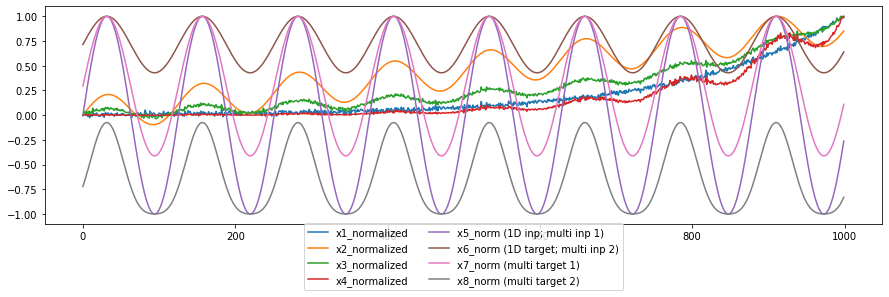

In [2]:
# Create surrogate sample data 

surrogate_samples = 1000
t = np.linspace(0, 50, surrogate_samples)

# inputs, outputs 
x1 = np.exp(0.1 * t) + np.random.normal(0, 2, surrogate_samples)
x2 = 10 * np.sin(t) + t 
x3 = x1 + x2 
x4 = x1 * x2 / 100 
x5 = np.sin(t) * 0.8
x6 = x5 * 0.2 + 0.4
x7 = x5 + x6 
x8 = x5 * x6 - 0.5

x1_factor = np.max(np.abs(x1))
x2_factor = np.max(np.abs(x2))
x3_factor = np.max(np.abs(x3))
x4_factor = np.max(np.abs(x4))
x5_factor = np.max(np.abs(x5))
x6_factor = np.max(np.abs(x6))
x7_factor = np.max(np.abs(x7))
x8_factor = np.max(np.abs(x8))


# normalize per time series
x1_normalized = x1 / x1_factor
x2_normalized = x2 / x2_factor
x3_normalized = x3 / x3_factor
x4_normalized = x4 / x4_factor
x5_normalized = x5 / x5_factor
x6_normalized = x6 / x6_factor
x7_normalized = x7 / x7_factor
x8_normalized = x8 / x8_factor


plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_normalized)), x1_normalized, label='x1_normalized')
plt.plot(range(len(x2_normalized)), x2_normalized, label='x2_normalized')
plt.plot(range(len(x3_normalized)), x3_normalized, label='x3_normalized')
plt.plot(range(len(x4_normalized)), x4_normalized, label='x4_normalized')
plt.plot(range(len(x5_normalized)), x5_normalized, label='x5_norm (1D inp; multi inp 1)')
plt.plot(range(len(x6_normalized)), x6_normalized, label='x6_norm (1D target; multi inp 2)')
plt.plot(range(len(x7_normalized)), x7_normalized, label='x7_norm (multi target 1)')
plt.plot(range(len(x8_normalized)), x8_normalized, label='x8_norm (multi target 2)')
plt.legend(loc = "center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [10]:
# Create windowed data 

# timeseries_dataset_from_array(data=x6_normalized,targets=None, sequence_length = seq_length, sequence_stride = 1, batch_size = batch_size, shuffle = False)

# window size 21
x5_windowed = create_rolling_windows(x5_normalized,200) # 1D input; multi input 1
x6_windowed = create_rolling_windows(x6_normalized,200) # 1D target; multi input 2
x7_windowed = create_rolling_windows(x7_normalized,200) # multi target 1
x8_windowed = create_rolling_windows(x8_normalized,200) # multi target 2 


surrogate_pairs = np.array([x5_windowed, x6_windowed])
surrogate_pairs = np.swapaxes(surrogate_pairs,0,1)
print("Shape surrogate pairs: " + str(surrogate_pairs.shape))
plt.plot(surrogate_pairs[200][0], label = "1D input") 
plt.plot(surrogate_pairs[200][1], label = "1D target")
plt.legend()
plt.show()

surrogate_quadruples = np.array([x5_windowed, x6_windowed, x7_windowed, x8_windowed])
surrogate_quadruples = np.swapaxes(surrogate_quadruples,0,1)
print("Shape surrogate quadrupels: " + str(surrogate_quadruples.shape))
plt.plot(surrogate_quadruples[200][0], label = "multi input 1") 
plt.plot(surrogate_quadruples[200][1], label = "multi input 2")
plt.plot(surrogate_quadruples[200][2], label = "multi target 1")
plt.plot(surrogate_quadruples[200][3], label = "multi target 2")
plt.legend()
plt.show()



Shape surrogate pairs: (980, 2, 21)


'\nplt.plot(surrogate_pairs[200][0], label = "1D input") \nplt.plot(surrogate_pairs[200][1], label = "1D target")\nplt.legend()\nplt.show()\n\nsurrogate_quadruples = np.array([x5_windowed, x6_windowed, x7_windowed, x8_windowed])\nsurrogate_quadruples = np.swapaxes(surrogate_quadruples,0,1)\nprint("Shape surrogate quadrupels: " + str(surrogate_quadruples.shape))\nplt.plot(surrogate_quadruples[200][0], label = "multi input 1") \nplt.plot(surrogate_quadruples[200][1], label = "multi input 2")\nplt.plot(surrogate_quadruples[200][2], label = "multi target 1")\nplt.plot(surrogate_quadruples[200][3], label = "multi target 2")\nplt.legend()\nplt.show()\n'

In [11]:
val_frac = 0.15 # amount of val; amount of test 

random.shuffle(surrogate_pairs)
num_val_samples = int(val_frac * len(surrogate_pairs))
num_train_samples = len(surrogate_pairs) - 2 * num_val_samples
train_pairs = surrogate_pairs[:num_train_samples]
val_pairs = surrogate_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = surrogate_pairs[num_train_samples + num_val_samples :]

print(f"{len(surrogate_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

980 total pairs
686 training pairs
147 validation pairs
147 test pairs


In [12]:
# Split pairs into inp and target 
train_inp_seqs = [pair[0] for pair in train_pairs]
train_target_seqs = [pair[1] for pair in train_pairs]
val_inp_seqs = [pair[0] for pair in val_pairs]
val_target_seqs = [pair[1] for pair in val_pairs]


print(np.shape(train_inp_seqs))
print(np.shape(train_target_seqs))
print(np.shape(val_inp_seqs))
print(np.shape(val_target_seqs))

batch_size = 128
sequence_length = 20
vocab_size = 15000


(686, 21)
(686, 21)
(147, 21)
(147, 21)


In [13]:
        
def make_dataset(input_seqs,target_seqs):
    ###input_seqs, target_seqs = zip(*pairs)
    #print(input_seqs)
    #print(target_seqs)
    ###input_seqs = list(input_seqs)
    ###target_seqs = list(target_seqs)
    
    input_seqs = np.array(input_seqs).astype(float)
    target_seqs = np.array(target_seqs).astype(float)
    
    print(input_seqs)
    
    # Create dataset with inp sequence <-> target sequence pairs (both have length sequence_length)
    dataset = tf.data.Dataset.from_tensor_slices((input_seqs, target_seqs)) # tuple makes sure that inp matches correct target

    # batch 
    dataset = dataset.batch(batch_size)
    
    # format input/ outputs omitting last elem for decoder input and skipping first elem for target 
    # idea: instead of "word by word", show everything and do not omit first or last 
    dataset = dataset.map(format_dataset)
    
    return dataset.shuffle(2048).prefetch(16).cache()



def format_dataset(inp, target):
    #inp = inp_vectorization(inp)
    #target = target_vectorization(target)
    
    print("format")
    for elem in inp:
        print(elem)
    print(np.shape(inp))
    print(np.shape(target))
    
    # transformer architecture -> proceed word by word
    # full target sequence for input (i.e. 20)
    # 0 to N for decoder input (i.e. 20)
    # 1 to N-1 for target -> shifted by one (i.e. 20)
    # TODO: Make rolling windows more clever, i.e. no need to cut inp
    
    return ({"encoder_inputs": inp[:, :-1], "decoder_inputs": target[:, :-1],}, target[:, 1:])
    #return ({"encoder_inputs": inp, "decoder_inputs": target[:, :-1],}, target)
    
    #return ({"encoder_inputs": inp, "decoder_inputs": target}, target)


'''
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()
'''

train_ds = make_dataset(train_inp_seqs,train_target_seqs)
val_ds = make_dataset(val_inp_seqs,val_target_seqs)

[[ 0.          0.05002916  0.09993302 ...  0.7838866   0.81396829
   0.84201141]
 [ 0.          0.05002916  0.09993302 ...  0.7838866   0.81396829
   0.84201141]
 [ 0.05002916  0.09993302  0.1495866  ...  0.81396829  0.84201141
   0.86794572]
 ...
 [ 0.99981483  0.99952556  0.99673299 ...  0.63587383  0.59646541
   0.55556315]
 [ 0.93927592  0.95526787  0.96886736 ...  0.85220096  0.82495781
   0.79564857]
 [ 0.79333605  0.76188565  0.72852712 ...  0.01536795 -0.03467455
  -0.0846302 ]]
format
Tensor("while/TensorArrayV2Read/TensorListGetItem:0", shape=(21,), dtype=float64)
(None, 21)
(None, 21)
[[-0.98297973 -0.99093986 -0.9964182  ... -0.75434704 -0.72055948
  -0.68496729]
 [-0.34680112 -0.29944256 -0.25133405 ...  0.51990736  0.56199235
   0.60266984]
 [-0.34680112 -0.29944256 -0.25133405 ...  0.51990736  0.56199235
   0.60266984]
 ...
 [ 0.9743015   0.96181248  0.94691461 ...  0.42837894  0.3826362
   0.33593515]
 [-0.42148467 -0.46632509 -0.5099976  ... -0.97255775 -0.98297973
  -

In [14]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 20)
inputs["decoder_inputs"].shape: (128, 20)
targets.shape: (128, 20)


# Basic model - 1D

In [109]:
X = np.array(train_inp_seqs)
Y = np.array(train_target_seqs)

tf.keras.backend.clear_session()

basic_model = keras.models.Sequential()
basic_model.add(layers.Dense(200, input_dim=200, activation='relu')) # relu
basic_model.add(layers.Dense(200, activation='relu')) # relu
basic_model.add(layers.Dense(200, activation='sigmoid')) # sigmoid
# compile the keras model
basic_model.compile(loss="mse", optimizer='adam', metrics=['accuracy'])
basic_model.summary()
# fit the keras model on the dataset
basic_model.fit(X, Y, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = basic_model.evaluate(X, Y)
print('Accuracy: %.2f' % (accuracy*100))



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               40200     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
Total params: 120,600
Trainable params: 120,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
57/57 [==============================] - 0s 1ms/step - loss: 0.0366 - accuracy: 0.0297
Epoch 2/150
57/57 [==============================] - 0s 1ms/step - loss: 6.8144e-04 - accuracy: 0.0857
Epoch 3/150
57/57 [==============================] - 0s 1ms/step - loss: 2.8974e-04 - accuracy: 0.1266
Epoch 4/150
57/57 [==============================] - 0s 1ms/step - loss: 1.

57/57 [==============================] - 0s 1ms/step - loss: 7.4915e-05 - accuracy: 0.1453
Epoch 73/150
57/57 [==============================] - 0s 1ms/step - loss: 5.4253e-05 - accuracy: 0.1566
Epoch 74/150
57/57 [==============================] - 0s 1ms/step - loss: 5.9792e-05 - accuracy: 0.1986
Epoch 75/150
57/57 [==============================] - 0s 860us/step - loss: 5.6776e-05 - accuracy: 0.1645
Epoch 76/150
57/57 [==============================] - 0s 866us/step - loss: 2.3797e-05 - accuracy: 0.1813
Epoch 77/150
57/57 [==============================] - 0s 911us/step - loss: 1.4334e-05 - accuracy: 0.1471
Epoch 78/150
57/57 [==============================] - 0s 894us/step - loss: 1.7321e-05 - accuracy: 0.1671
Epoch 79/150
57/57 [==============================] - 0s 1ms/step - loss: 2.7090e-05 - accuracy: 0.1649
Epoch 80/150
57/57 [==============================] - 0s 2ms/step - loss: 2.3501e-05 - accuracy: 0.1468
Epoch 81/150
57/57 [==============================] - 0s 2ms/step - l

18/18 [==============================] - 0s 870us/step - loss: 8.6834e-05 - accuracy: 0.2032
Accuracy: 20.32


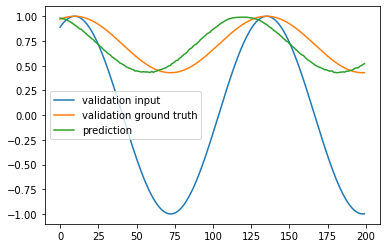

In [113]:
val_inp = np.array([val_inp_seqs[80]])
val_true = np.array([val_target_seqs[80]])
val_pred = basic_model.predict(val_inp)


plt.plot(val_inp[0], label = "validation input")
plt.plot(val_true[0], label = "validation ground truth")
plt.plot(val_out[0], label = "prediction")
plt.legend()
plt.show()


# Basic Model - Multi dimensional

In [124]:
surrogate_quadruples

val_frac = 0.15 # amount of val; amount of test 

random.shuffle(surrogate_quadruples)
num_val_samples = int(val_frac * len(surrogate_quadruples))
num_train_samples = len(surrogate_quadruples) - 2 * num_val_samples
train_quads = surrogate_quadruples[:num_train_samples]
val_quads = surrogate_quadruples[num_train_samples : num_train_samples + num_val_samples]
test_quads = surrogate_quadruples[num_train_samples + num_val_samples :]

print(f"{len(surrogate_quadruples)} total quads")
print(f"{len(train_quads)} training quads")
print(f"{len(val_quads)} validation quads")
print(f"{len(test_quads)} test quads")






801 total quads
561 training quads
120 validation quads
120 test quads


In [154]:
X = np.array(train_quads[:,0:2,:])
X = X.reshape(X.shape[0],-1)
Y = np.array(train_quads[:,2:,:])
Y = Y.reshape(Y.shape[0],-1)

tf.keras.backend.clear_session()

basic_model_multi = keras.models.Sequential()
basic_model_multi.add(layers.Dense(400, input_dim = X.shape[1], activation='tanh')) # relu
basic_model_multi.add(layers.Dense(400, activation='tanh')) # relu
basic_model_multi.add(layers.Dense(400, activation='tanh')) # sigmoid
# compile the keras model
basic_model_multi.compile(loss="mse", optimizer='adam', metrics=['accuracy'])
basic_model_multi.summary()
# fit the keras model on the dataset
basic_model_multi.fit(X, Y, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = basic_model_multi.evaluate(X, Y)
print('Accuracy: %.2f' % (accuracy*100))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
Total params: 481,200
Trainable params: 481,200
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
57/57 [==============================] - 0s 2ms/step - loss: 0.0988 - accuracy: 0.0294
Epoch 2/150
57/57 [==============================] - 0s 3ms/step - loss: 0.0021 - accuracy: 0.0619
Epoch 3/150
57/57 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.0970
Epoch 4/150
57/57 [==============================] - 0s 2ms/step - loss: 0.0032 - a

57/57 [==============================] - 0s 2ms/step - loss: 2.1577e-04 - accuracy: 0.2049
Epoch 75/150
57/57 [==============================] - 0s 2ms/step - loss: 2.5109e-04 - accuracy: 0.2125
Epoch 76/150
57/57 [==============================] - 0s 2ms/step - loss: 6.2826e-04 - accuracy: 0.2199
Epoch 77/150
57/57 [==============================] - 0s 2ms/step - loss: 4.7511e-04 - accuracy: 0.2638
Epoch 78/150
57/57 [==============================] - 0s 2ms/step - loss: 6.1048e-04 - accuracy: 0.1970
Epoch 79/150
57/57 [==============================] - 0s 2ms/step - loss: 4.1838e-04 - accuracy: 0.2447
Epoch 80/150
57/57 [==============================] - 0s 2ms/step - loss: 3.7371e-04 - accuracy: 0.2138
Epoch 81/150
57/57 [==============================] - 0s 2ms/step - loss: 3.7192e-04 - accuracy: 0.2419
Epoch 82/150
57/57 [==============================] - 0s 2ms/step - loss: 3.2836e-04 - accuracy: 0.2048
Epoch 83/150
57/57 [==============================] - 0s 2ms/step - loss: 3.2

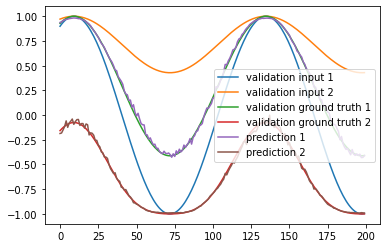

In [159]:
# use from train dataset 
if False:
    val_inp = np.array([X[200,:]])
    val_true = np.array([Y[200,:]])
# use actual validation 
else:
    val_inp = np.array(val_quads[:,0:2,:])
    val_inp = val_inp.reshape(val_inp.shape[0],-1)
    val_inp = np.array([val_inp[100,:]])
    val_true = np.array(val_quads[:,2:4,:])
    val_true = val_true.reshape(val_true.shape[0],-1)
    val_true = np.array([val_true[100,:]])
    
val_out = basic_model_multi(val_inp) # predict 
    

plt.plot(val_inp[0][0:200], label = "validation input 1")
plt.plot(val_inp[0][200:400], label = "validation input 2")
plt.plot(val_true[0][0:200], label = "validation ground truth 1")
plt.plot(val_true[0][200:400], label = "validation ground truth 2")
plt.plot(val_out[0][0:200], label = "prediction 1")
plt.plot(val_out[0][200:400], label = "prediction 2")
plt.legend()
plt.show()

# Transformer Model

In [15]:


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        
        print("Encoder SHape")
        print(self.layernorm_2(proj_input + proj_output))
        return self.layernorm_2(proj_input + proj_output)

    
    

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        
        # dummy 
        vocab_size = 20
        
        ### no need for token embedding 
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim 
        )
        ###
        
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        
        ### no need for token embedding 
        embedded_tokens = self.token_embeddings(inputs)
        ### 
        
        embedded_positions = self.position_embeddings(positions)
        
        '''
        print(embedded_tokens)
        print(embedded_positions)
        print(inputs)
        print()
        print(embedded_positions + inputs)
        '''
        
        return embedded_tokens + embedded_positions # original
        #return tf.expand_dims(embedded_positions, axis=0)
        #return embedded_positions + inputs # no need for token embedding, instead add actual numbers 
        
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    
    
    

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        
        print("Decoder Shaper")
        print(self.layernorm_3(out_2 + proj_output))
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)



In [16]:
embed_dim = 256
latent_dim = 2048
num_heads = 8


encoder_inputs = keras.Input(shape=(None,), dtype="float64", name="encoder_inputs")
x_encoder = PositionalEmbedding(sequence_length, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x_encoder)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="float64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x_decoder = PositionalEmbedding(sequence_length, embed_dim)(decoder_inputs)
x_decoder = TransformerDecoder(embed_dim, latent_dim, num_heads)(x_decoder, encoded_seq_inputs)
x_decoder = layers.Dropout(0.5)(x_decoder)

# decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x) # orig
#decoder_outputs = layers.Dense(sequence_length, activation="softmax")(x_decoder)
decoder_outputs = layers.Dense(20, activation="softmax")(x_decoder)




#decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])



transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)



Encoder SHape
Tensor("transformer_encoder_1/layer_normalization_6/add:0", shape=(None, None, 256), dtype=float32)
Decoder Shaper
Tensor("transformer_decoder_1/layer_normalization_9/add:0", shape=(None, None, 256), dtype=float32)
Decoder Shaper
Tensor("model_3/transformer_decoder_1/layer_normalization_9/add:0", shape=(None, None, 256), dtype=float32)


In [17]:
#error_sq = tf.math.squared_difference(y_pred, y_true)

def custom_mse(y_true, y_pred):
    
    print(y_true)
    print(y_pred)
    
    #squared_difference = tf.square(y_true - y_pred[:,0,:])
    squared_difference = tf.square(y_true - y_pred[:,:,-1]) # last entry of each
    
    return tf.reduce_mean(squared_difference)  # Note the `axis=-1`


In [18]:
epochs = 3  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss=custom_mse, metrics=["accuracy"] # sparse_categorical_crossentropy # mse
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding_2 (Positio (None, None, 256)    10240       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder_1 (Transfor (None, None, 256)    3155456     positional_embedding_2[0][0]     
________________________________________________________________________________________

In [ ]:

max_decoded_sequence_length = 20

def decode_sequence(input_sequence):
    decoded_sequence = np.array([])
    for i in range(max_decoded_sequence_length):
        
        predictions = transformer([np.array([input_sequence]), np.array([decoded_sequence])])
        
        sampled_token = np.max(predictions[0, i, :]) # verify this
        decoded_sequence = decoded_sequence.add(sampled_token)
    
    return decoded_sequence

print(train_inp_seqs[0][:-1])
print(decode_sequence(train_inp_seqs[0][:-1]))


In [ ]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)